# COVID19 Scholarly Article Analysis

## Innovation

The scientific community has responded to the COVID-19 pandemic with massive research efforts, including research into vaccines, medication, mitigation of the virus' spread, improved testing, and so on. This has resulted in a surge of publication of scientific articles on the topic of the COVID-19 disease. Researchers aiming to review literature on COVID-19 can benefit from analysis that reveals hidden relations between articles or groupings of articles, as they could use such analysis to help them discover articles relating to their area of research. We performed natural language processing and corpus analysis on an open dataset of scientific articles on the topic of COVID-19. This analysis may reveal underlying relations and associations between these scientific articles, which researchers can use to arrive at novel or faster insight in their efforts to counter the pandemic.

## Source Data

The source data for this analysis is the COVID-19 Open Research Dataset compiled by leading researchers in cooperation with the U.S. Government. The dataset contains over 135,000 scholarly articles relating to the topic of COVID-19 and SARS-CoV-2. It is available here:

https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge

## Preprocessing

Since the dataset is composed of raw text json files, the data needed to be preprocessed into a numerical form before it could be analyzed. The abstract and body text sections were extracted from each json file, split into word lists, converted to all lower-case, and scrubbed of punctuation, non-alphabetic words, and stop words. Stem words were taken from the resulting word lists and stored in csv format with a corresponding file ID. At the same time, vocabulary lists were collected for each text. The lists belonging to the same sources (such as arxiv, noncomm_use_subset, custom_license, biorxiv_medrxiiv) were combined in order to create a document-term count matrix.

Below is the code for data preprocessing and vocabulary collection:

In [ ]:
# extract the abstract and body-text text from all json files in a folder
# clean up before analysis
# arxiv file as an example

import os
import json
import numpy
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

# some functions setting up
table = str.maketrans('', '' ,string.punctuation)
porter = PorterStemmer()
d = numpy.empty(1)

# read every json file in the folder
path_to_json = 'CORD-19-research-challenge/arxiv/arxiv/pdf_json/'
json_files = [jf for jf in os.listdir(path_to_json) if jf.endswith('.json')]
i = 0
for index, js in enumerate(json_files):
    with open(os.path.join(path_to_json, js)) as f:
        data = json.load(f)

    file_name = data["paper_id"]
    cleaned_file = numpy.empty(1)
    i = i+1
    print(i)
    print(file_name)

    # get the text from abstract part
    for p in data["abstract"]:
        # split the sentences into words
        words = word_tokenize(p["text"])
        # lower case
        words = [w.lower() for w in words]
        # remove punctuation from each word
        words = [w.translate(table) for w in words]
        # remove the words not in alphabetic
        words = [w for w in words if w.encode('UTF-8').isalpha()]
        # filter out stop words
        stop_words = set(stopwords.words('english'))
        words = [w for w in words if not w in stop_words]
        # transfer to stem words
        words = [porter.stem(w) for w in words]
        # print("body_text: ", words)
        cleaned_file = numpy.append(cleaned_file, words)
        d = numpy.append(d, words)
        d = numpy.unique(d)
        
    # get the text from body_text part
    for p in data["body_text"]:
        # split the sentences into words
        words = word_tokenize(p["text"])
        # lower case
        words = [w.lower() for w in words]
        # remove punctuation from each word
        words = [w.translate(table) for w in words]
        # remove the words not in alphabetic
        words = [w for w in words if w.encode('UTF-8').isalpha()]
        # filter out stop words
        stop_words = set(stopwords.words('english'))
        words = [w for w in words if not w in stop_words]
        # transfer to stem words
        words = [porter.stem(w) for w in words]
        # print("body_text: ", words)
        cleaned_file = numpy.append(cleaned_file, words)
        d = numpy.append(d, words)
        d = numpy.unique(d)
    print("\n")
    cleaned_file = cleaned_file[1:]
    file_name = 'cleaned_file/arxiv/arxiv_pdf'+file_name +'.csv'
    numpy.savetxt(file_name, cleaned_file, fmt = "%s", delimiter = ';')
    
d = d[1:]
numpy.savetxt("arxiv_vocabulary.csv", d, fmt = "%s", delimiter = ';')


In [ ]:
# the amount of files is large, we have splited into several folders, run on different computers
# and now we need to combine everything together
# combine all cvs files to obtain a vocabulary table
# noncomm_use_subset_pmc as an example

import os
import numpy
import string
import csv

# read every json file in the folder

dir_path = 'cleaned_file/noncomm_use_subset/noncomm_use_subset_pmc/noncomm_use_subset_pmc'
data = []
for i in range(0,3):
    subdir_path = dir_path + str(i)
    print(subdir_path)
    file = [f for f in os.listdir(subdir_path) if f.endswith('.csv')]
    for r in file:
        print(r)
        path = subdir_path+'/'
        path = path + r
        with open(path, 'r') as file:
            fileReader = csv.reader(file, delimiter = ';')
            data1 = numpy.array(list(fileReader)).astype(str)

        data = numpy.append(data, data1)
        data = numpy.unique(data)

numpy.savetxt("noncomm_use_subset_pmc_vocabulary.csv", data, fmt = "%s", delimiter = ';')



## Kmeans Clustering
Using the preprocessed data, a document-term count matrix (DT matrix) was constructed, in which the rows of the DT matrix represent the vocabulary list, and the columns represent the text file list, for the files from each source. In order to speed up the process, the DT matrix was translated into a sparse matrix format, and then the sparse matrix was transformed into a term frequency-inverse document frequency matrix (TF-IDF matrix). For the clustering process, K-means was applied to the TF-IDF matrix. To find an optimal K value, the K-means algorithm was run several times, with K ranging from 1 to 19. The models were saved for further analysis.

In [ ]:
import re
import os
import pandas
import json
import numpy
import string
import nltk
import csv
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.cluster import KMeans
from sklearn.externals import joblib

# construct a dictionary vector
# path may need to be changed
path = 'covid19_schorlar_analysis/vocabulary.csv'
with open(path, 'r') as file:
    fileReader = csv.reader(file, delimiter = ';')
    dictionary = numpy.array(list(fileReader)).astype(str)

# contruct a word-count matrix
# get a list of all files in the certain folder
# path may need to be changed
path = 'covid19_schorlar_analysis/cleaned_file/biorxiv_medrxiv/biorxiv_medrxiv_pdf/'
file_list = [f for f in os.listdir(path) if f.endswith('.csv')]
# i: file index
i = 0
# f_list: file index and indexed file
f_list = numpy.zeros(2)
# matrix: word count matrix
matrix = numpy.zeros(len(dictionary))
# read every file to complete word counting
for index, f in enumerate(file_list):
    temp = numpy.array([i, f])
    print(temp)
    f_list = numpy.r_[f_list, temp.T]
    with open(os.path.join(path, f),'r') as file:
        fileReader = csv.reader(file, delimiter = ';')
        data = numpy.array(list(fileReader)).astype(str)

    count = numpy.zeros(len(dictionary))
    for word in data:
        j = numpy.where(dictionary == word)
        count[j[0]] += 1

    matrix = numpy.c_[matrix, count]
    i += 1

print(matrix)

matrix = matrix[:, 1:]
matrix = matrix.T

f_list = f_list[2:]
l = len(f_list)/2
l = int(l)
f_list = f_list.reshape([l, 2])

# index need to be changed 
numpy.savetxt('biorxiv_medrxiv_index.csv', f_list, fmt = '%s', delimiter = ';')

# transfer to sparse matrix
matrix_csr = csr_matrix(matrix)
# transfer to Tfidf matrix
transformer = TfidfTransformer()
matrix_tfidf = transformer.fit_transform(matrix_csr)
# k-means cluster: k in range(1,20)
for k in range(1, 20):
    # set up
    km = KMeans(n_clusters = k)
    # fit model
    km.fit(matrix_tfidf)
    # save model
    model_name = 'k' + str(k) + '.m'
    joblib.dump(km, model_name)


## Analysis
### SSE analysis

To analyze the clustering results of different K values, the sum of squares of error (SSE) was obtained from each K model and plotted into a linear graph.

#### Arxiv
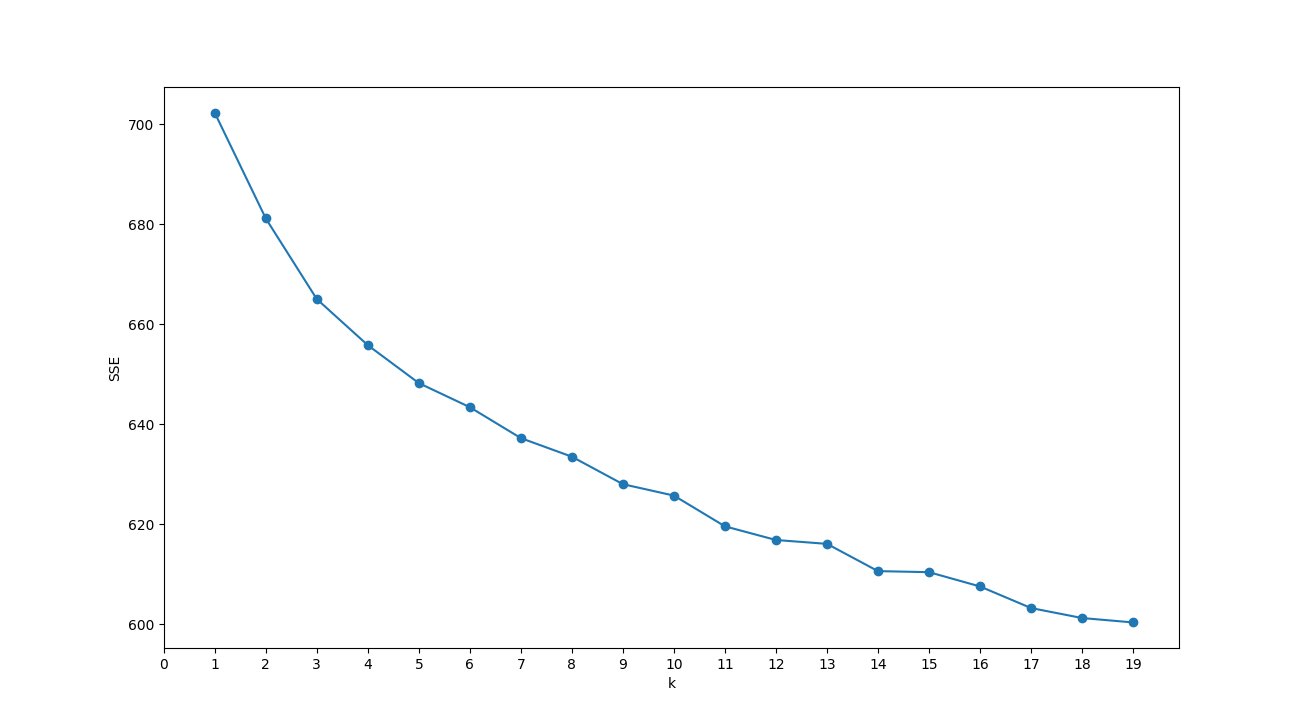

#### biorxiv_medrxiv
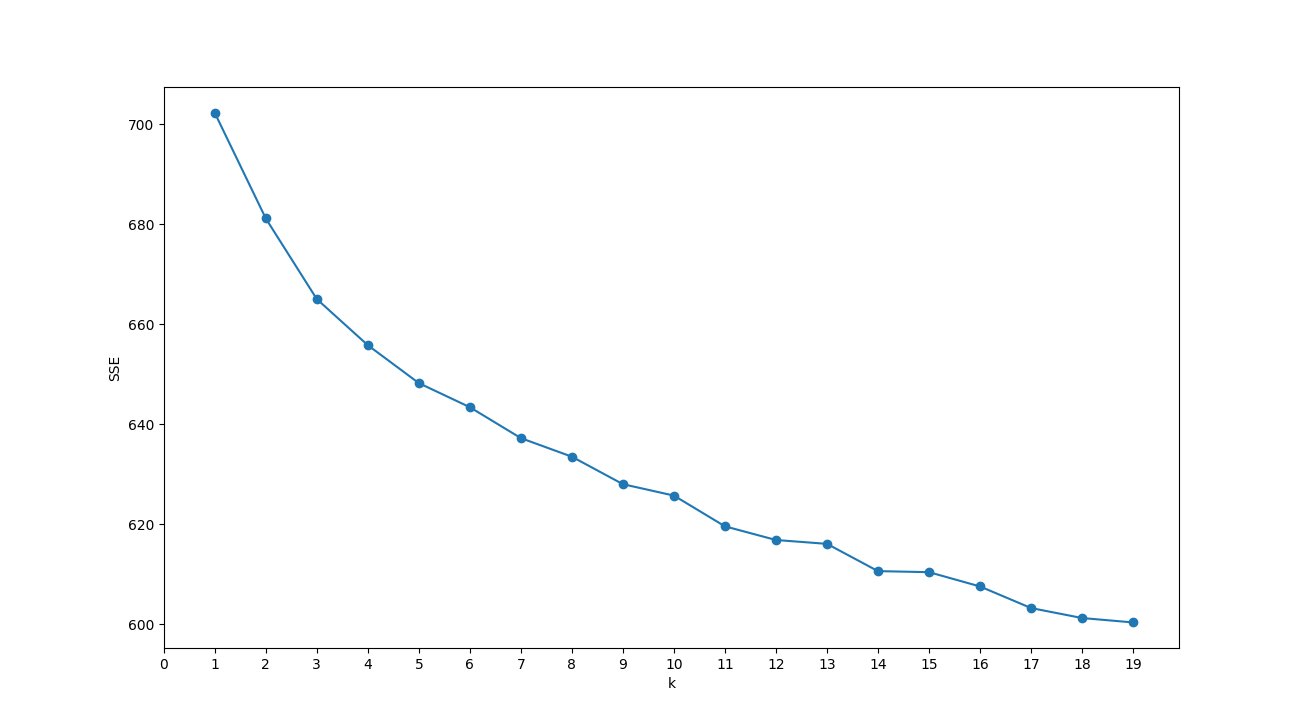

#### noncomm_use_subeset
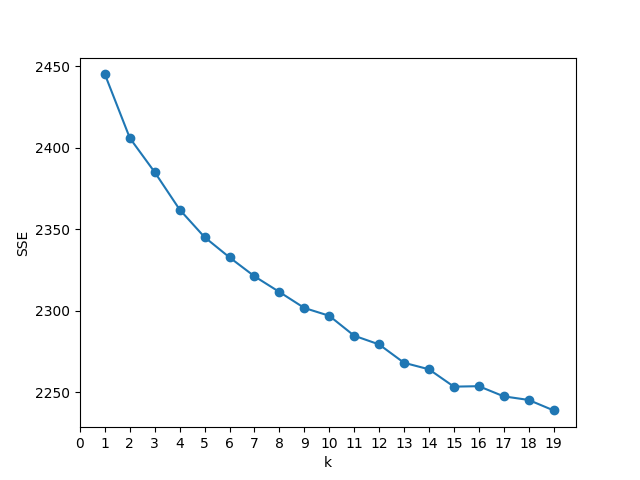

#### comm_use_subset
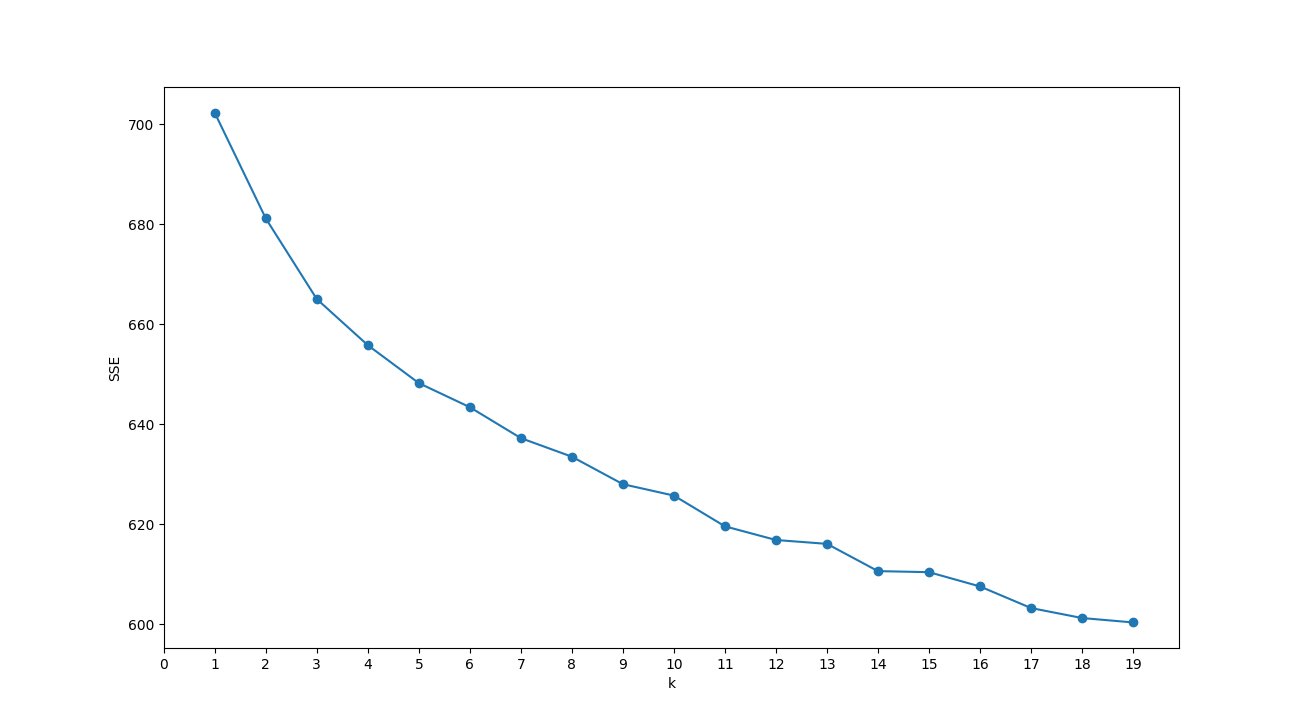


In each graph, the SSE values appear to decrease while the K values increase. The SSE values decrease rapidly at the beginning of the graph, but their decrease slows down with increasing K values. Therefore, SSE will remain stable at some K value, and the K value at this inflection point is optimal. More analysis is necessary to find the inflection point, but it is certain that its K value is smaller than or equal to 8.

### Visualization (PCA and t-SNE)

Principle Component Analysis (PCA) and t-distributed Stochastic Neighbor Embedding (t-SNE) were applied to reduce the dimension of the TF-IDF matrix to project the visualization results onto two-dimensional images where K ranges from 1 to 8. The 10 words which have highest frequency in each cluster at various K values are listed.

### Arxiv
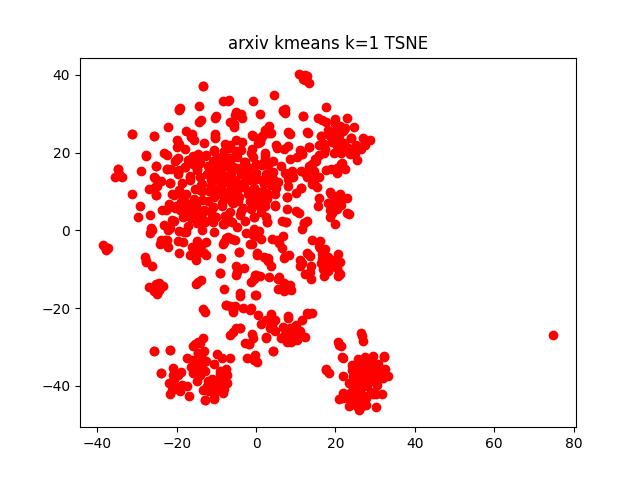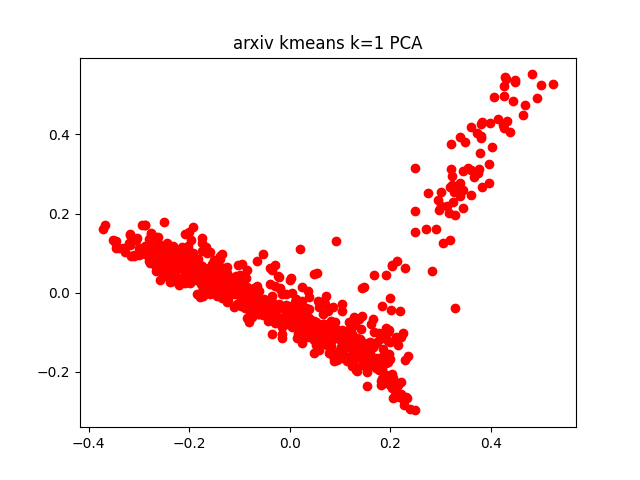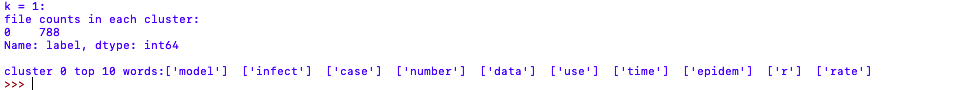
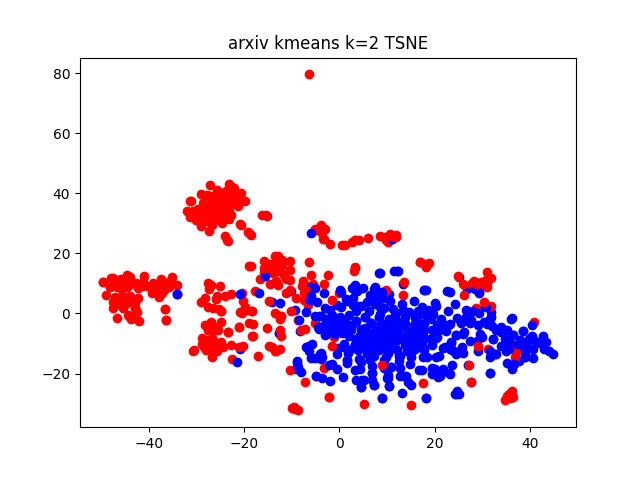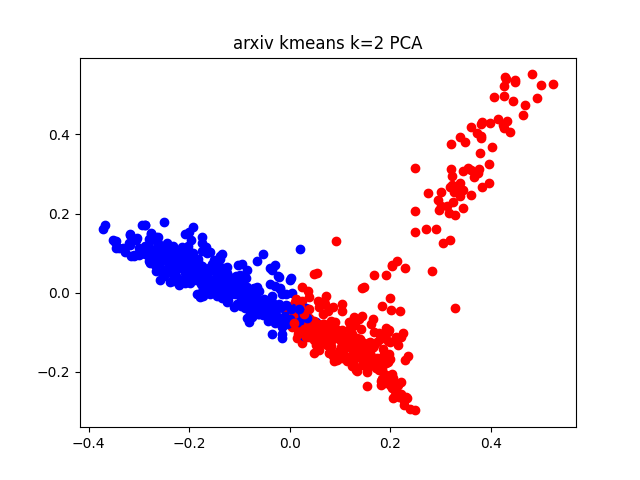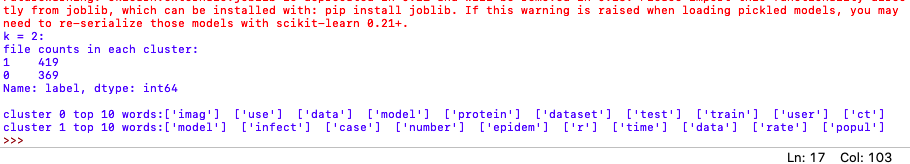
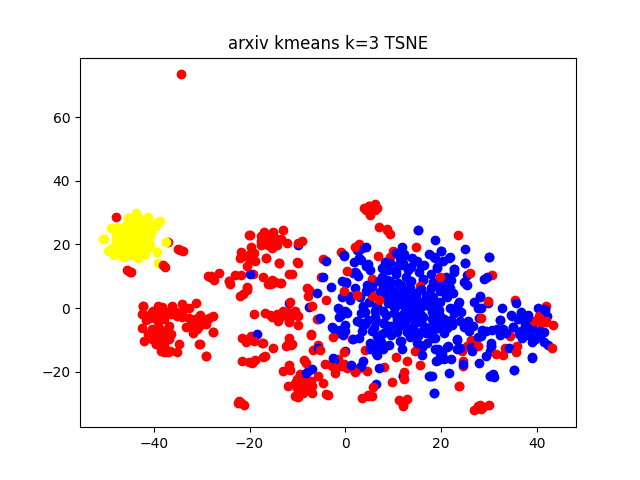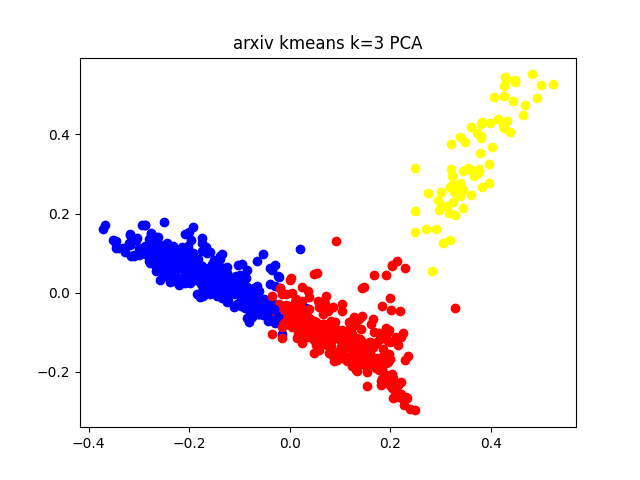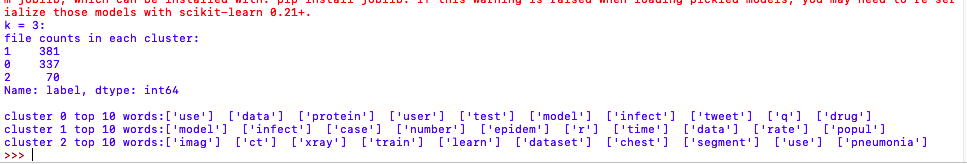
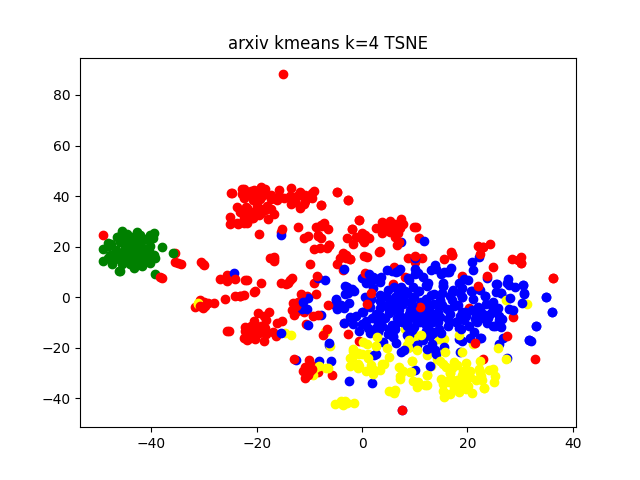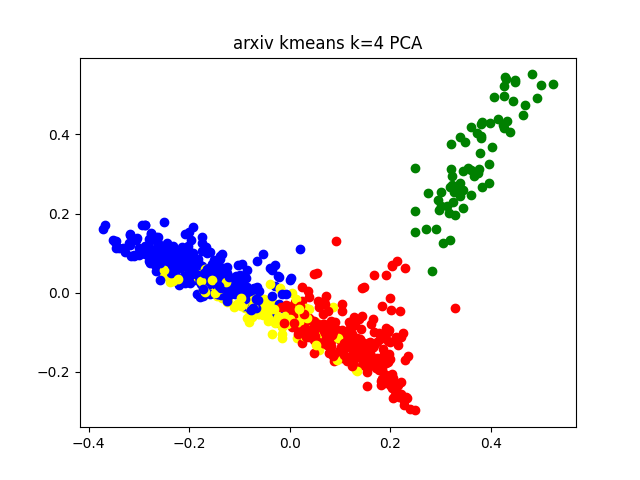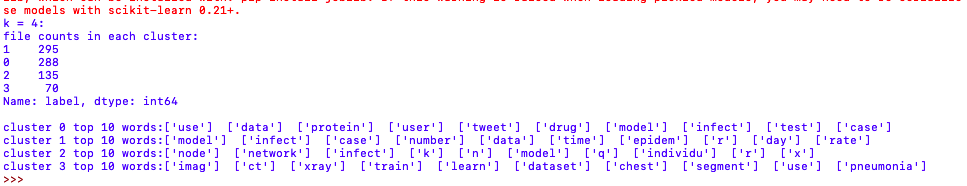
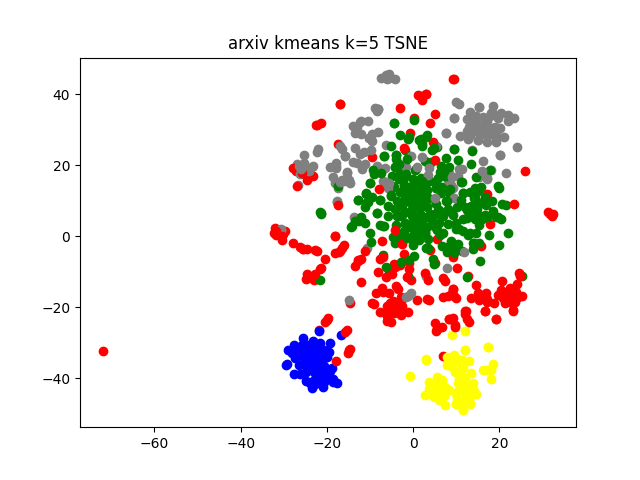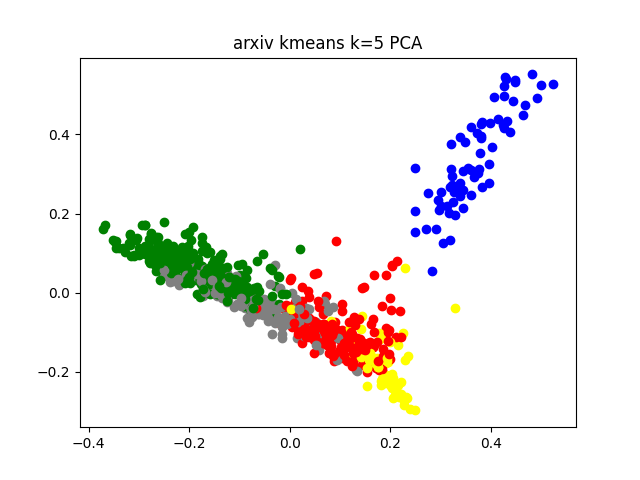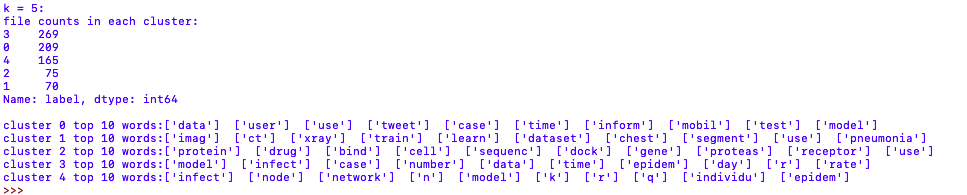
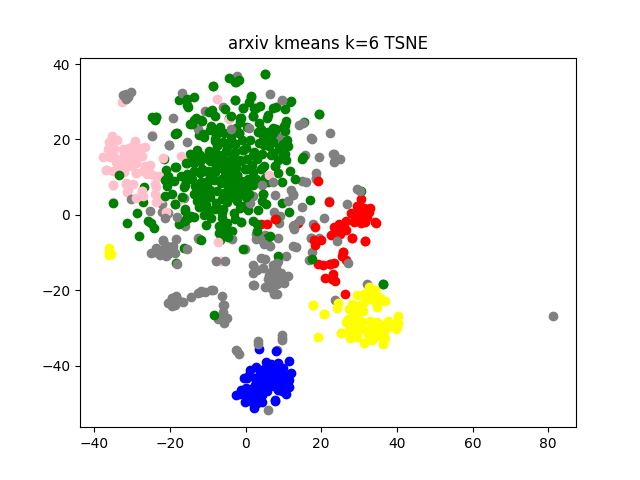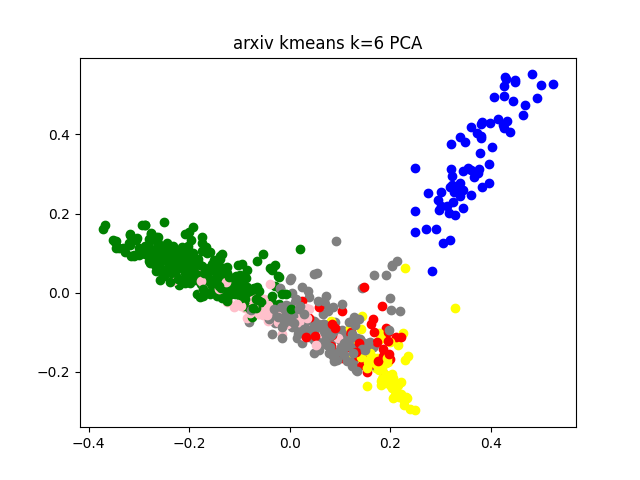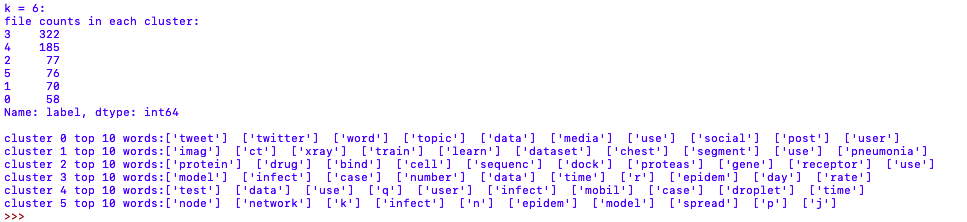
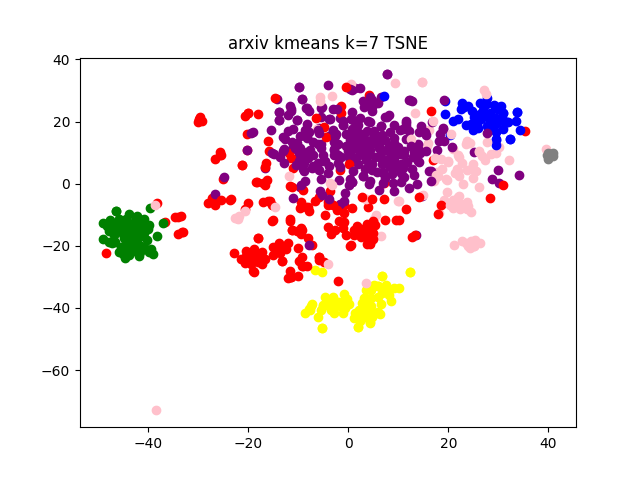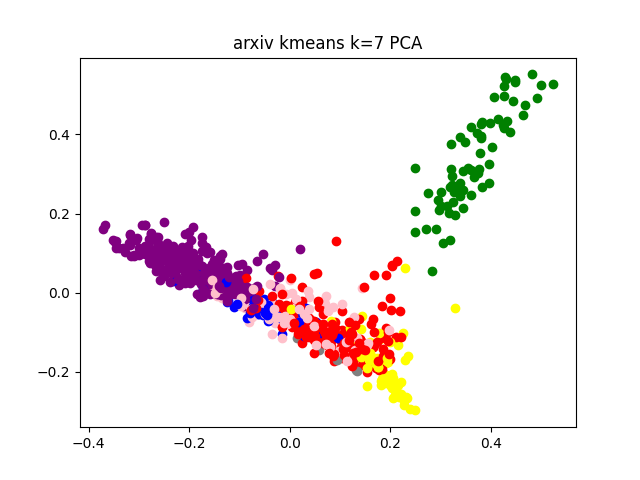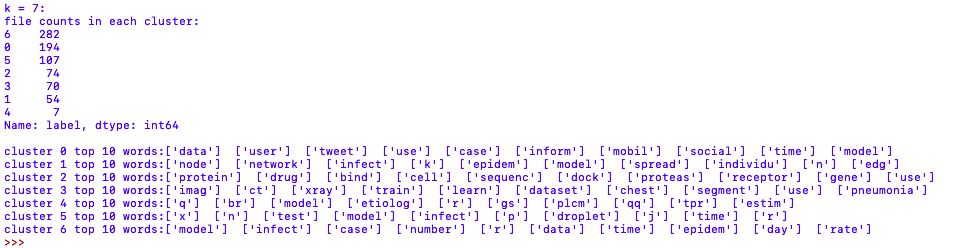
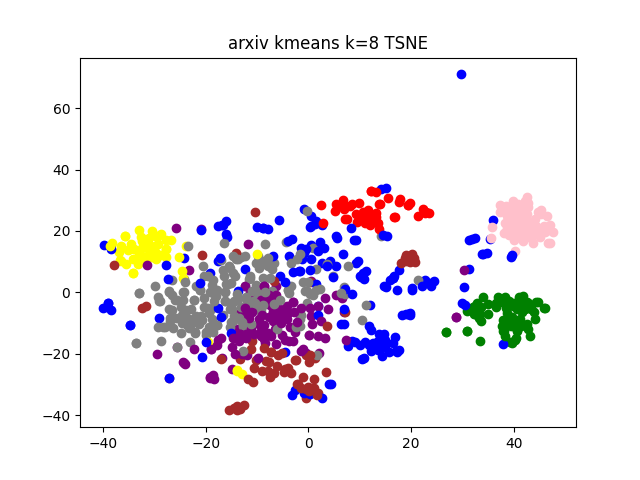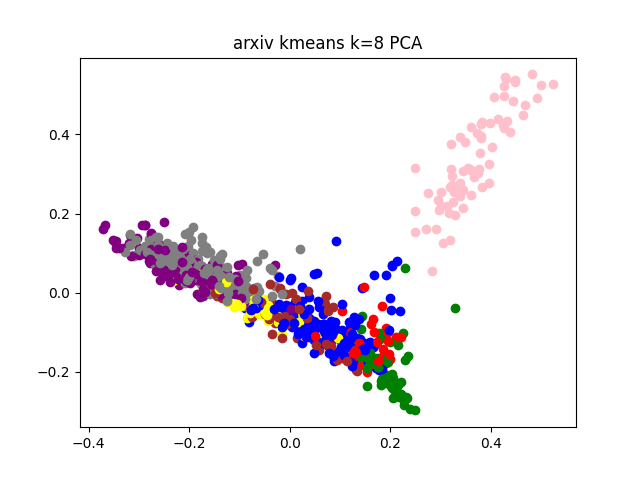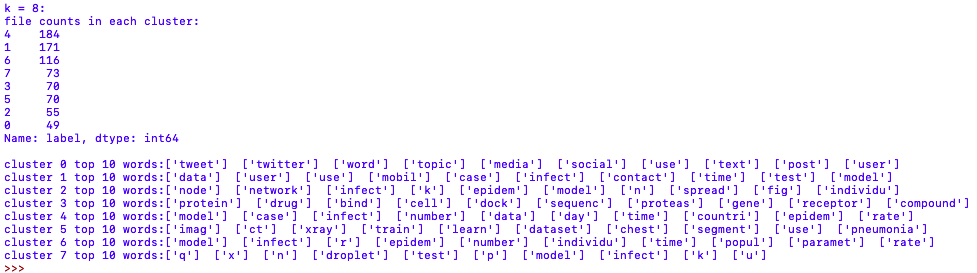

Based on the graphs, K = 3 should be the optimal value. The following is the result from recovering the stem words of each cluster when K = 3:

Cluster 0: use, data, protein, user, test, model, infect, tweet, q, drug

Cluster 1: model, infect, case, number, epidemic, r, time, data, rate, popular

Cluster 2: image, ct, xray, train, learn, dataset, chest, segment, use, pneumonia

Cluster 0 outlines that researchers attempt to gather infection-related information from Twitter's user data, such as people's drug use, and build models.

Cluster 1 outlines several key factors in epidemiological studies, the speed of transmission, the time span of transmission, and the number of people affected.

Cluster 2 mentions pneumonia, which is very similar to COVID-19, and X-ray images of the chest, possibly in an attempt to aid diagnosis and treatment with machine learning.

### biorxiv_medrxiv
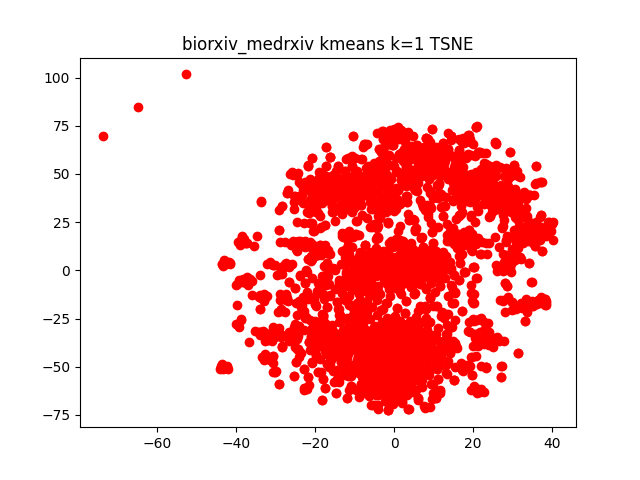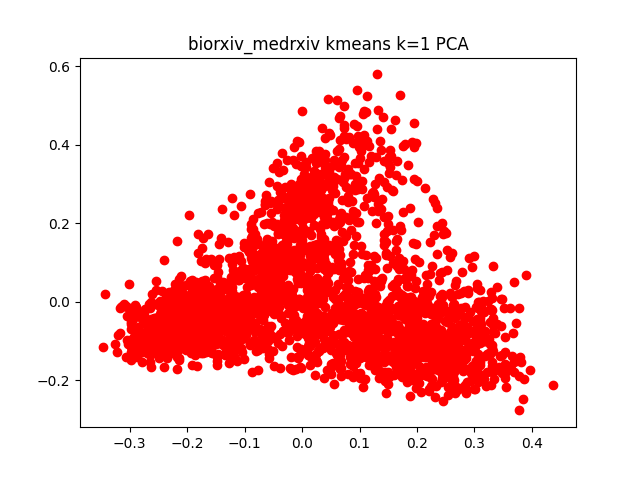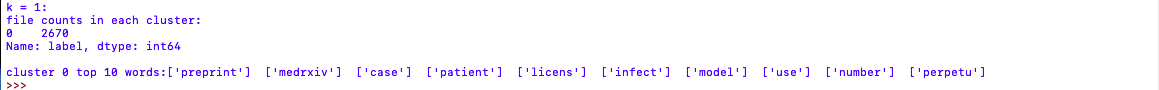
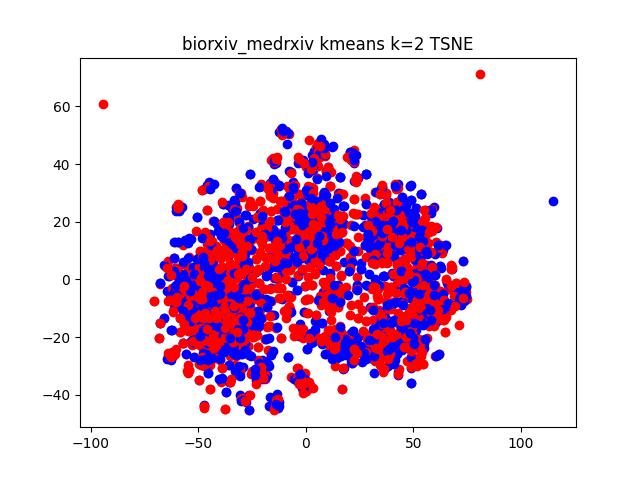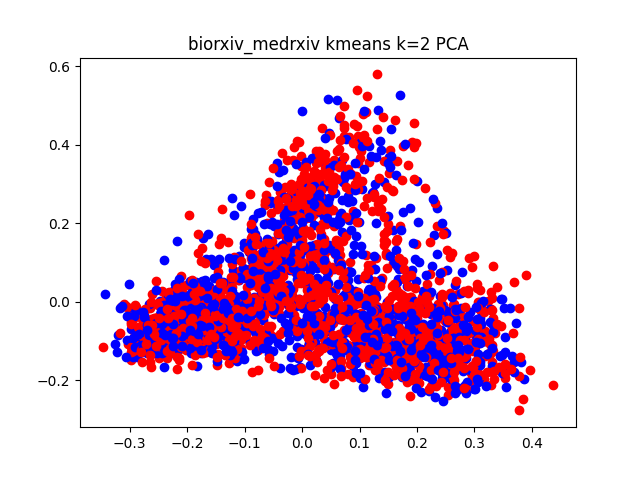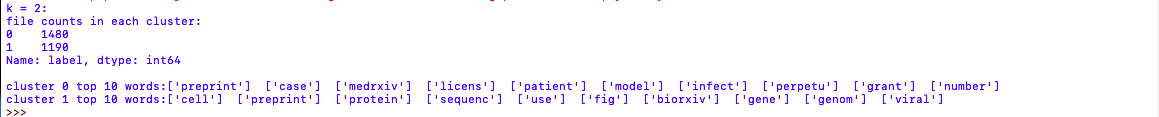
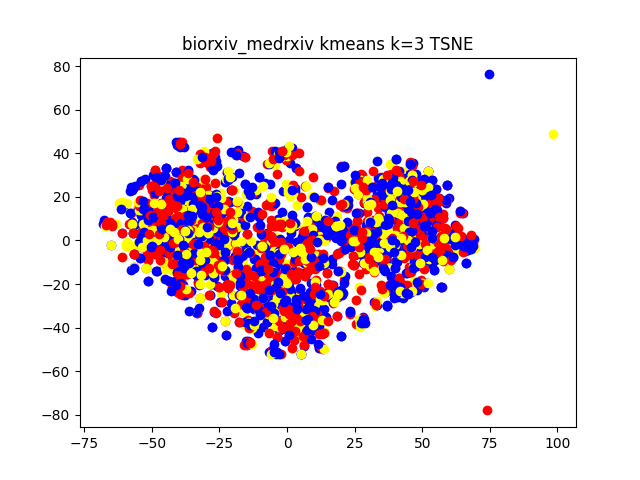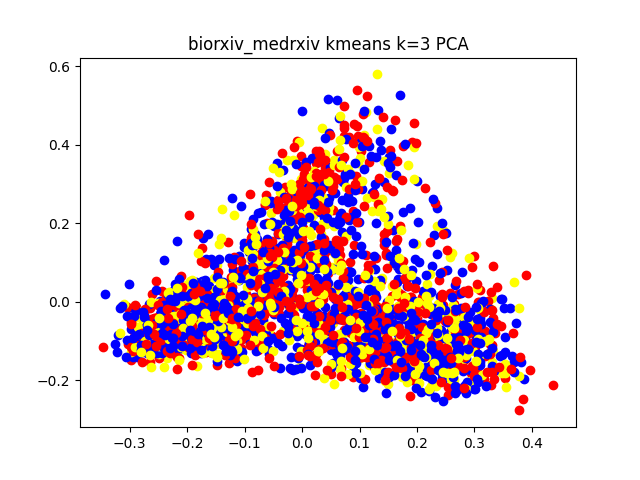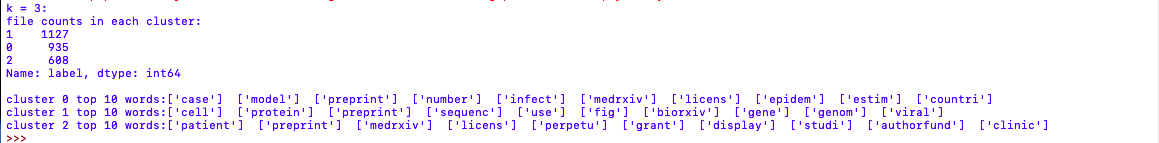
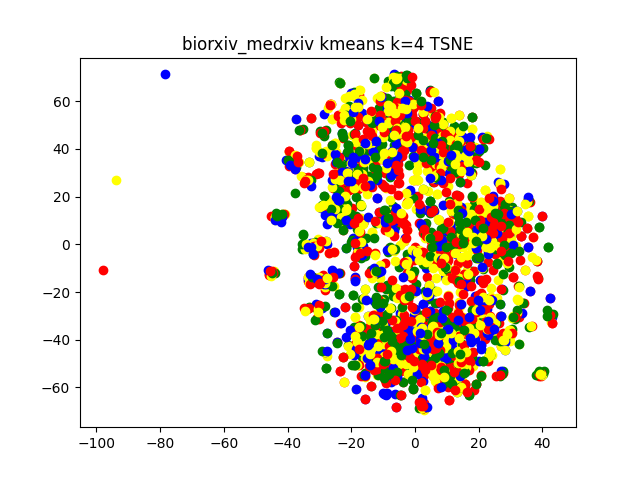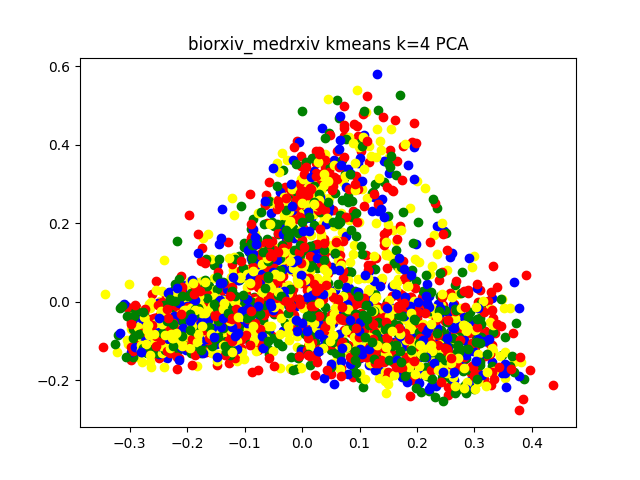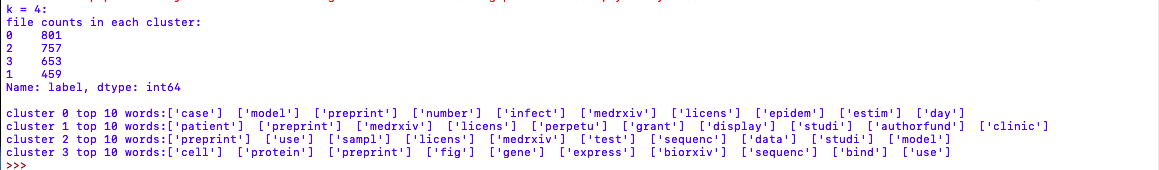
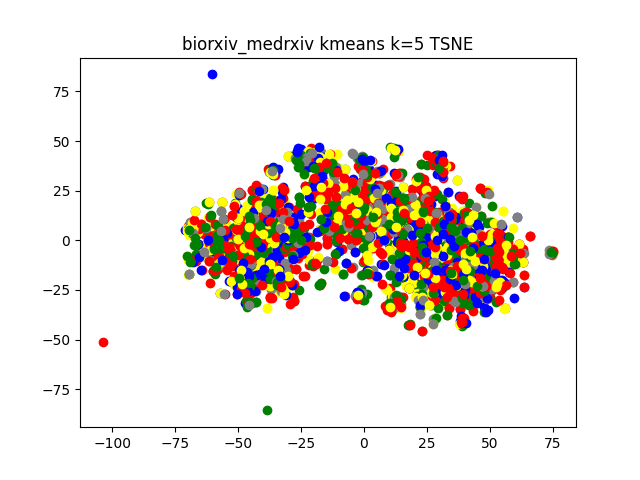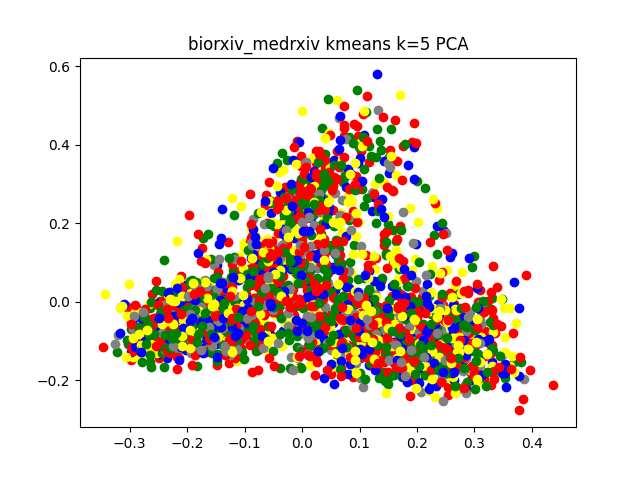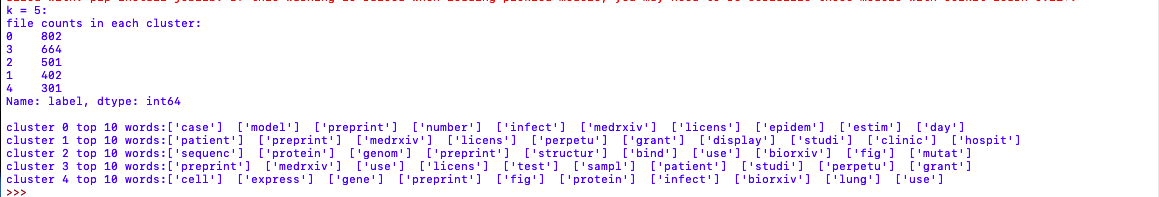
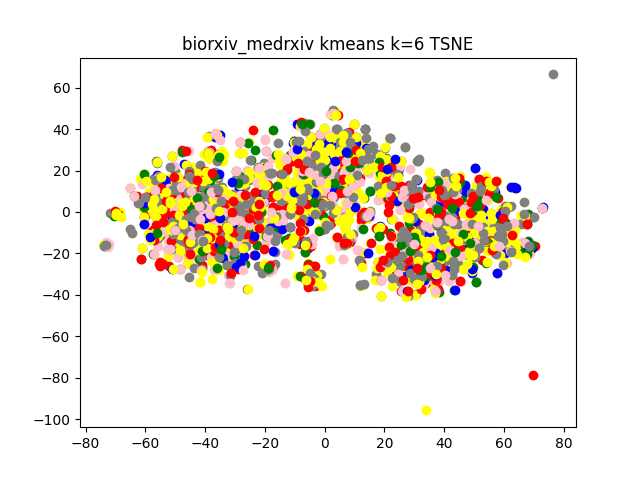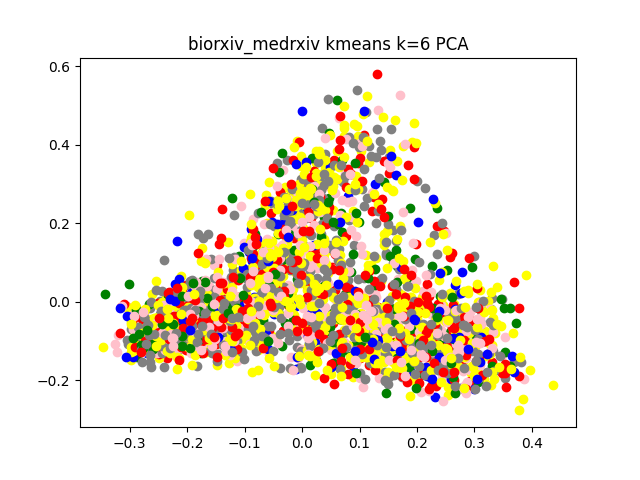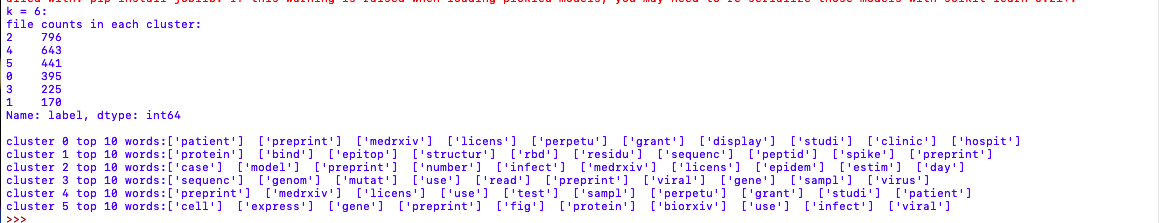
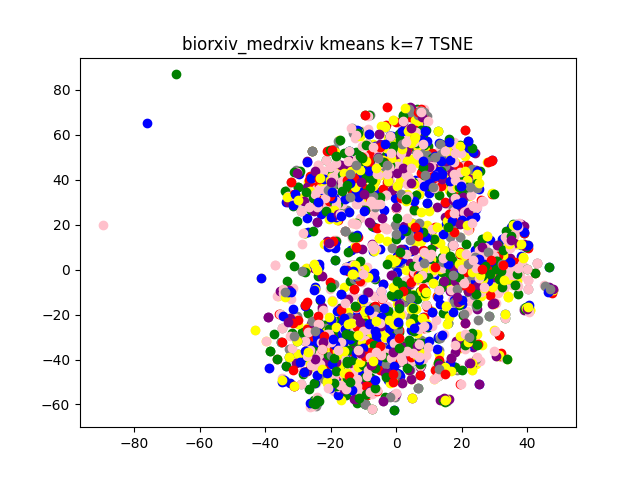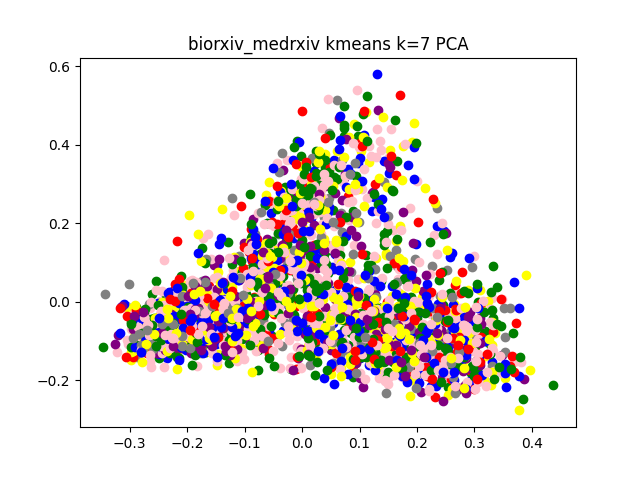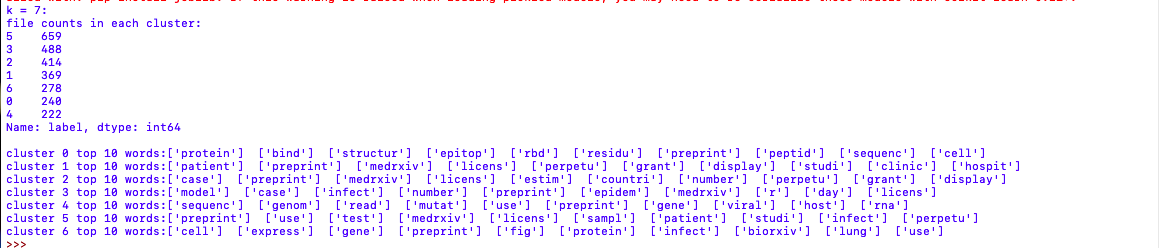
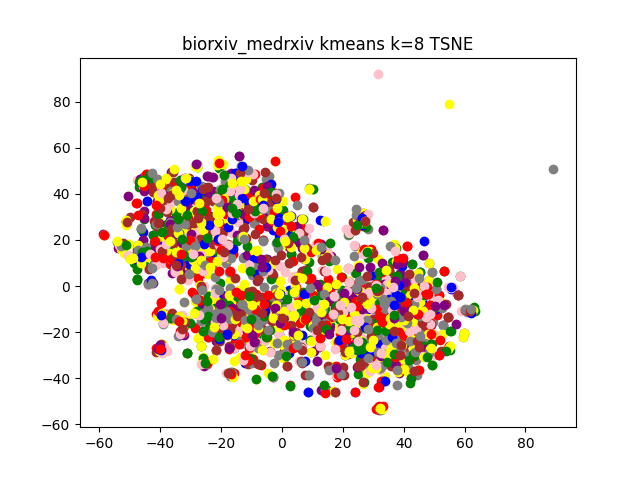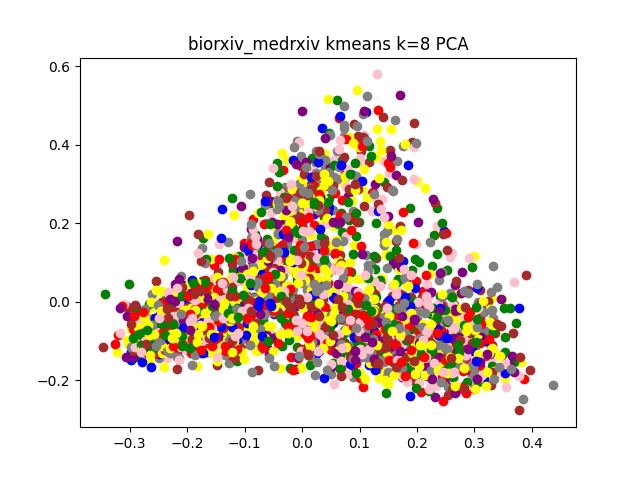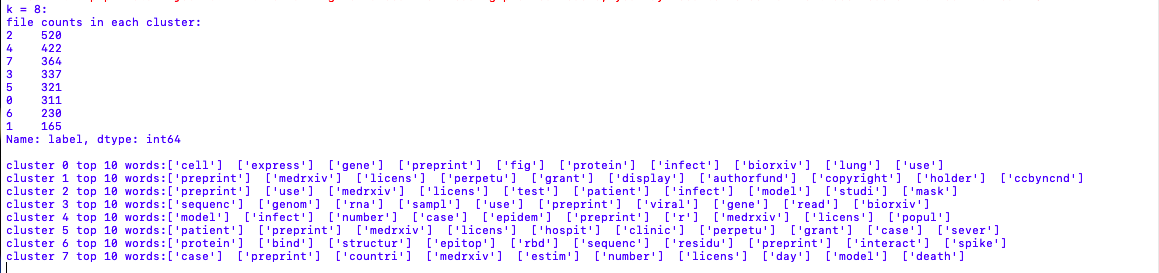

The classified images of this source showed no obvious pattern, and it was generally seen from the keywords that these papers were also about virus research and hospital data analysis.


### noncomm_use_subeset
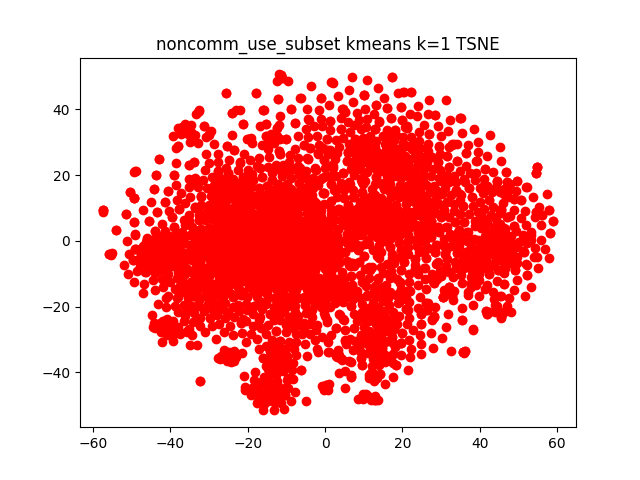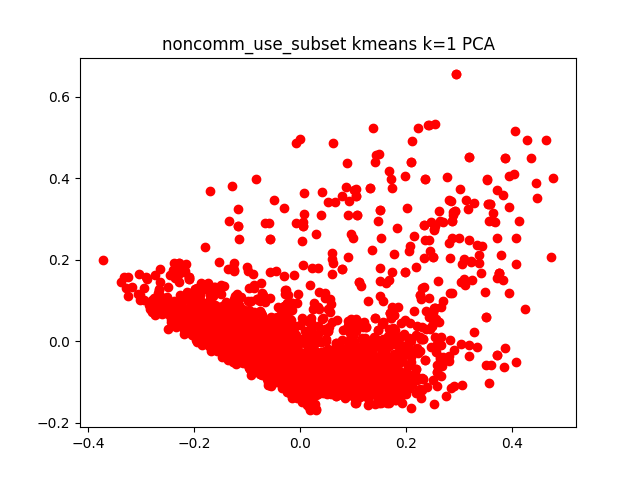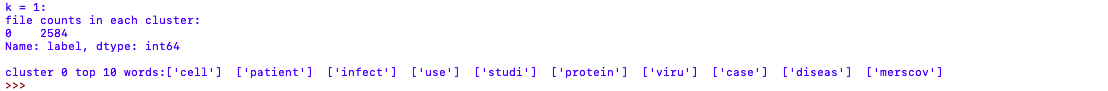
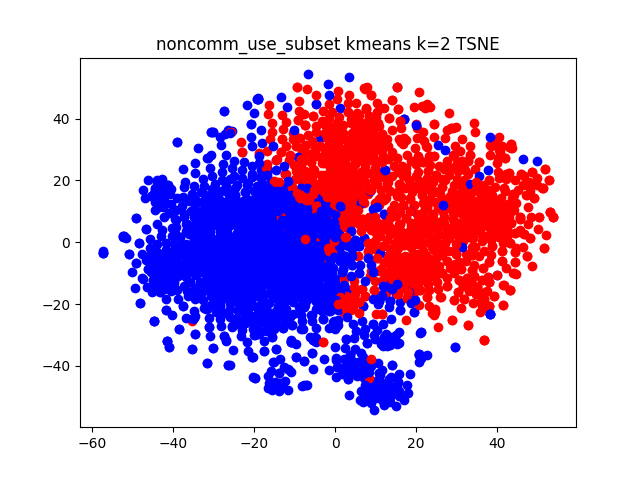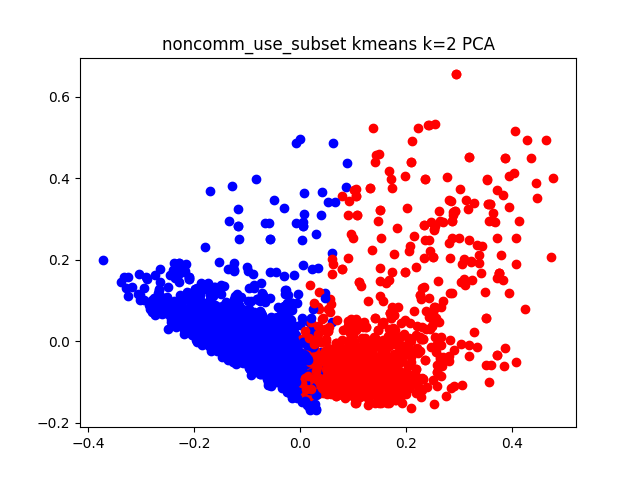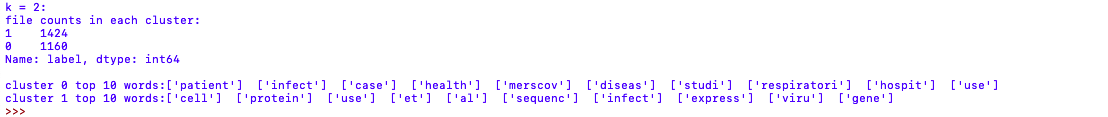
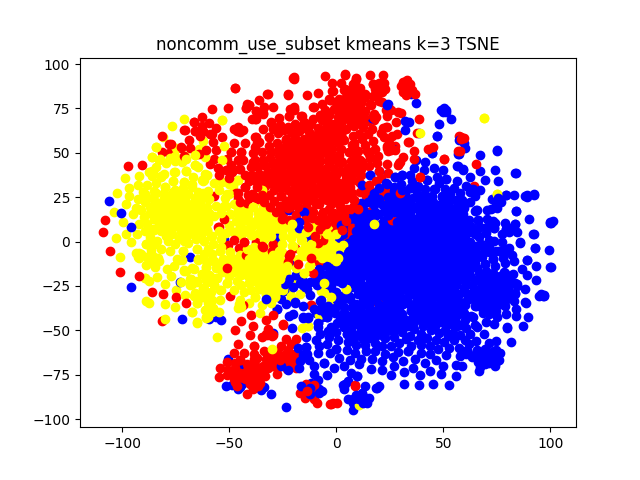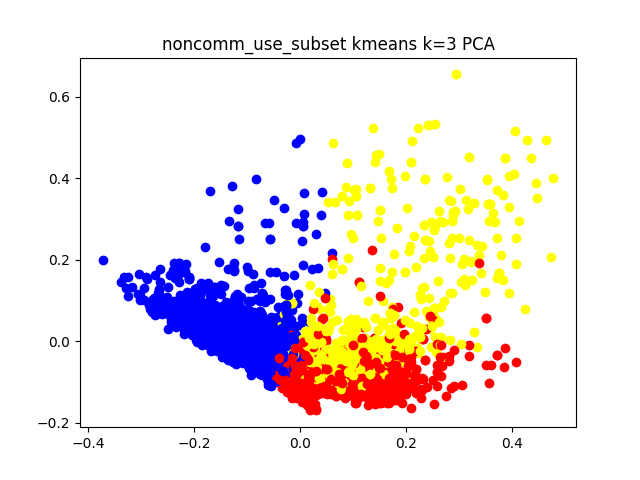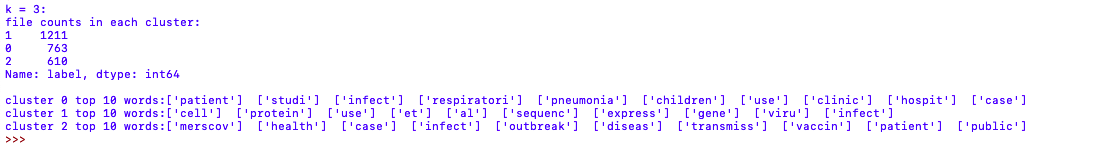
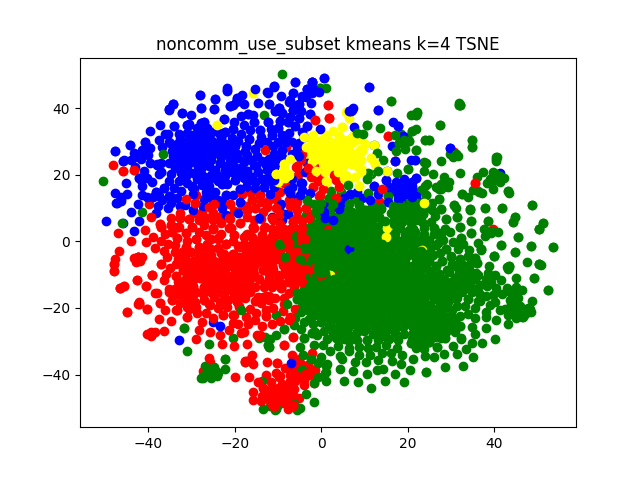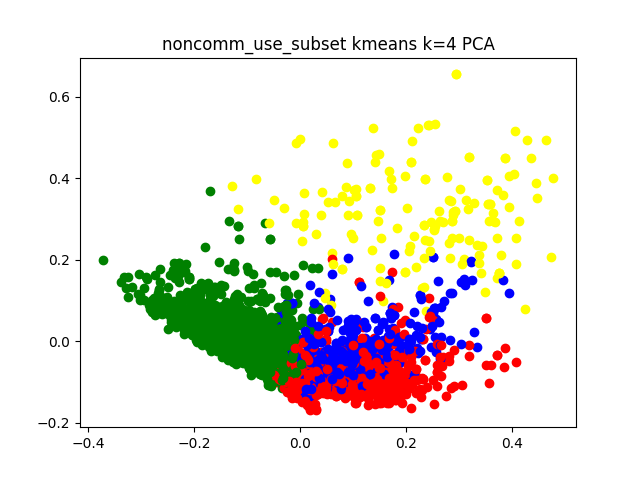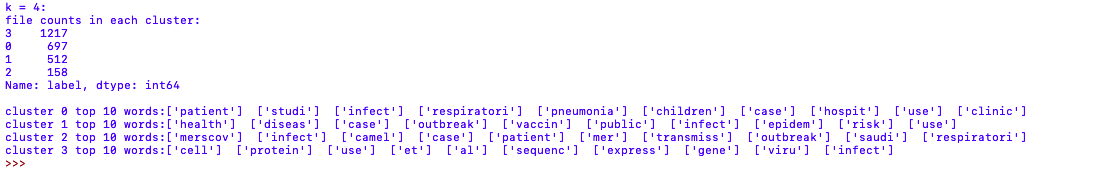
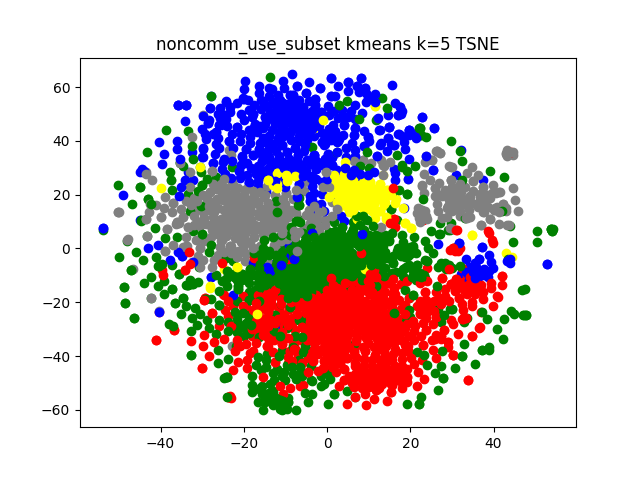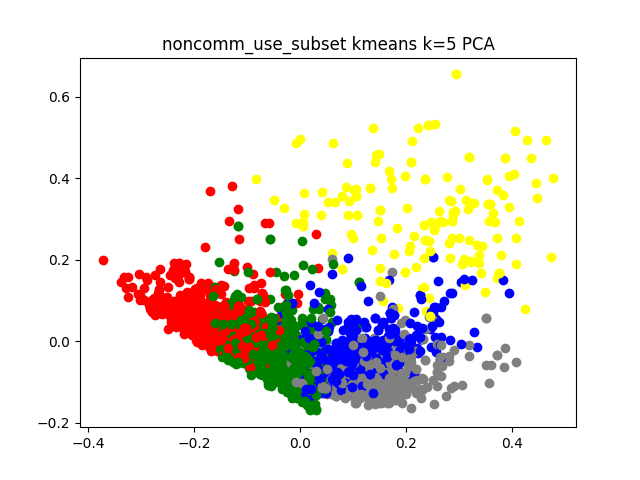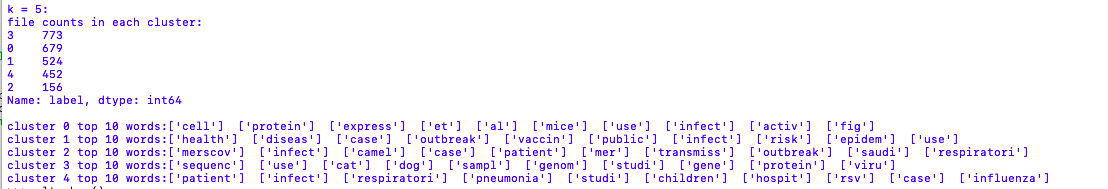
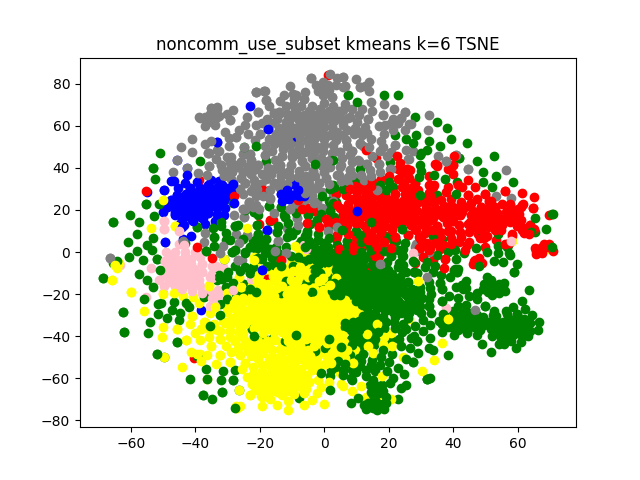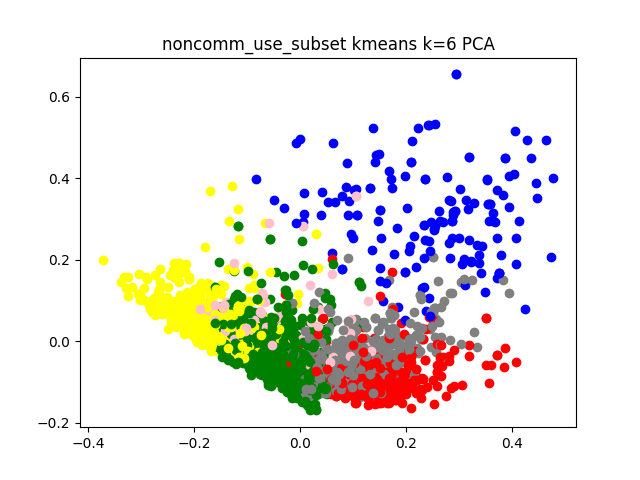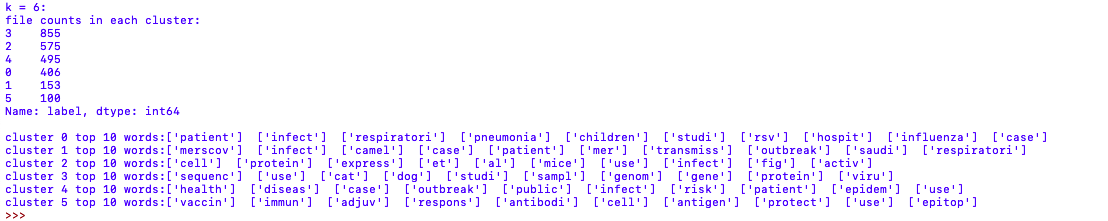
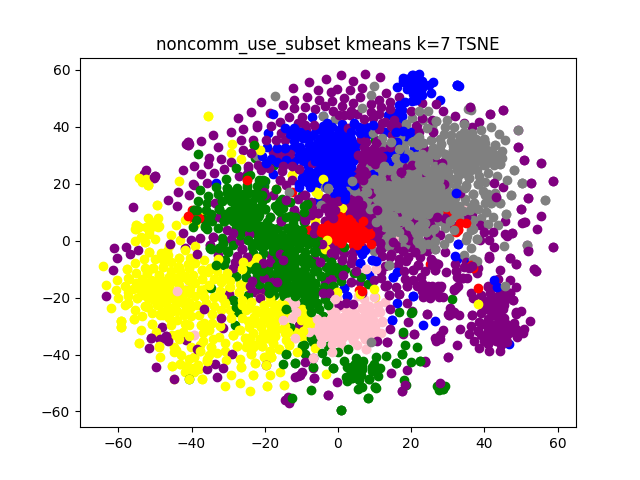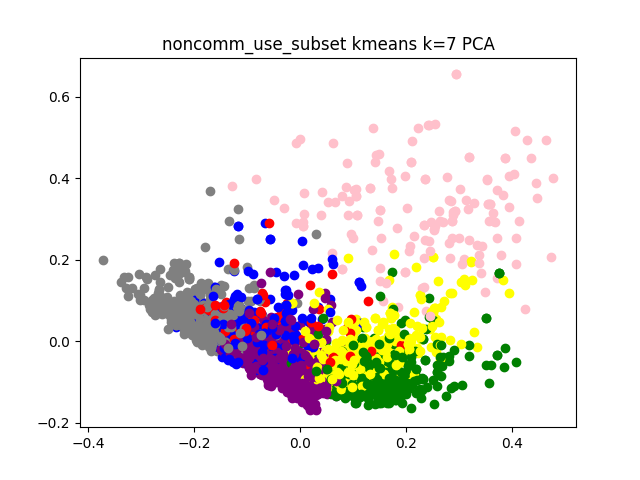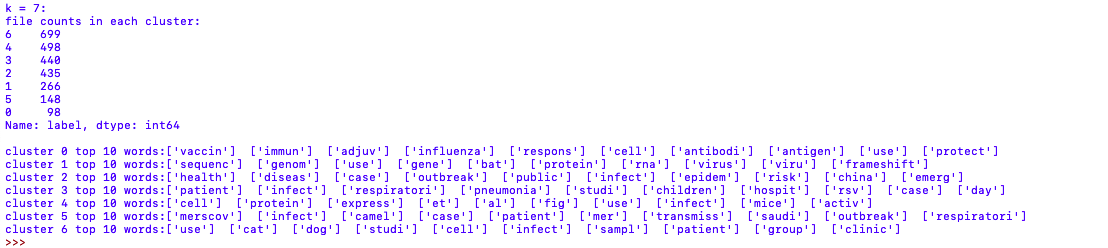
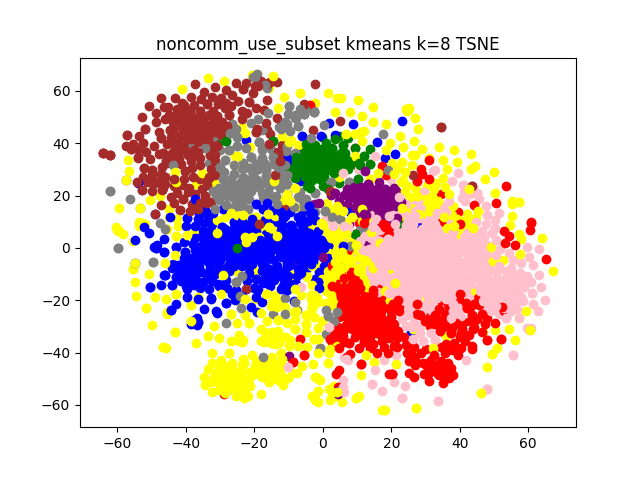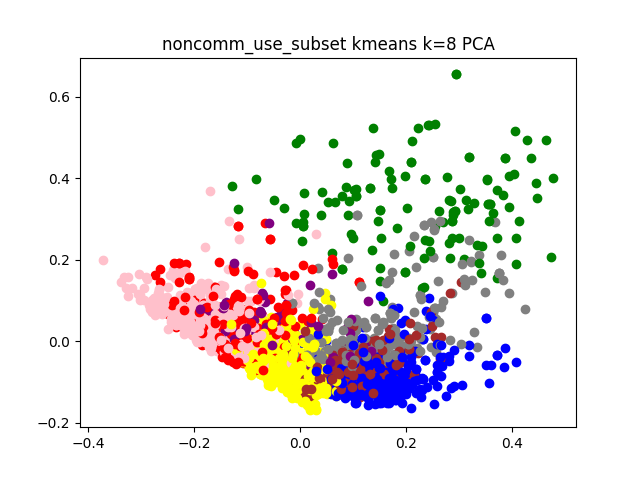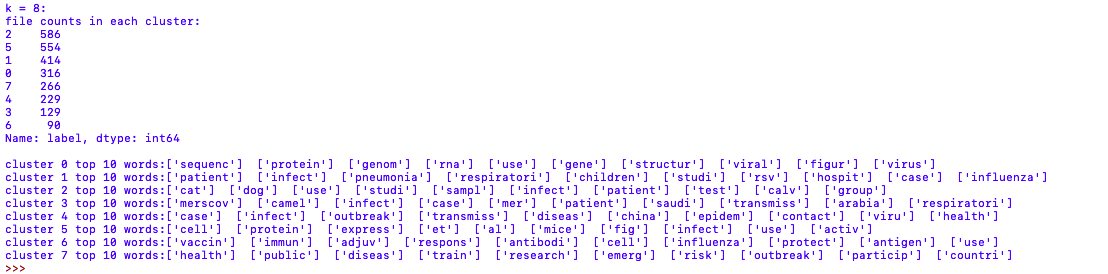

In above graphs, K = 4 appears to be optimal, and the following words are recovered:

Cluster 0: patient, study, infect, respiratory, pneumonia, children, case, hospital, use, clinic

Cluster 1: health, disease, case, outbreak, vaccine, public, infect, epidemic, risk, use

Cluster 2: Merscov, infect, camel, case, patient, mer, transmission, outbreak, Saudi, respiratory

Cluster 3: cell, protein, use, et, al, sequence, express, gene, virus, infect

Cluster0 outlines concerns about the risk of novel Coronavirus infection in a pneumonia patient, with concern for children cases among them.

Cluster1 outlines the public health risks of an outbreak and sets out to develop a vaccine.

Cluster2 outlines the outbreak and spread of pneumonia and the virus in the Saudi region, with camels as a possible cause.

Cluster3 outlines the novel Coronavirus biological study, including the analysis of gene chains, proteins and DNA in VIUR region.


### comm_use_subset
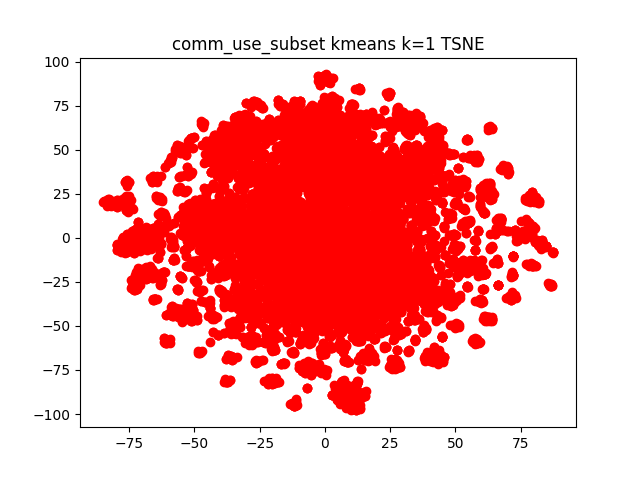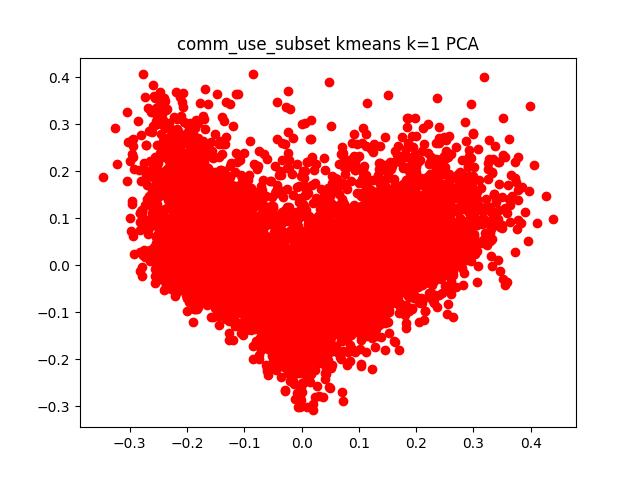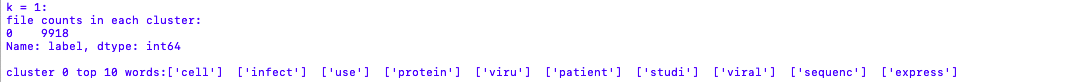
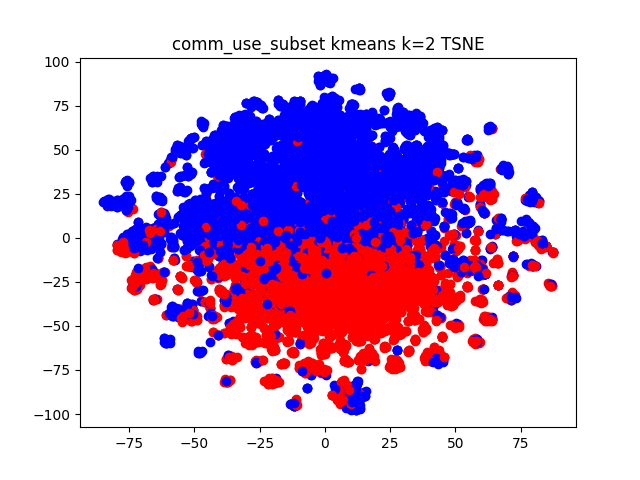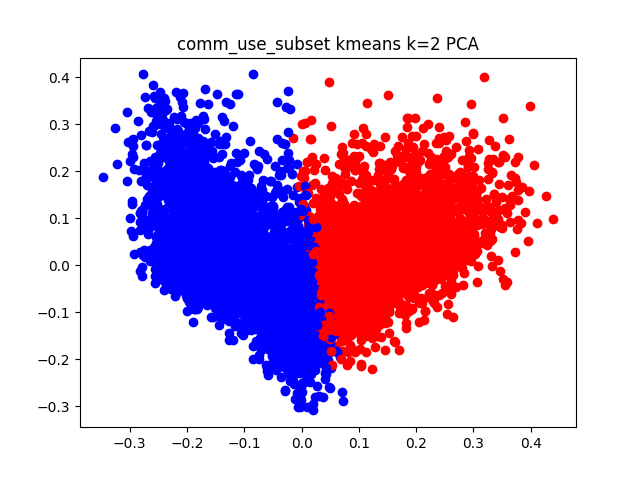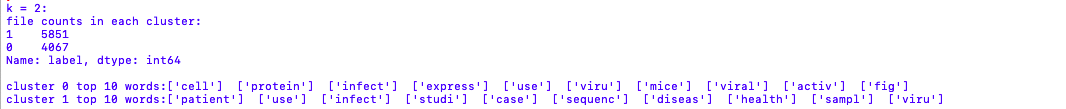
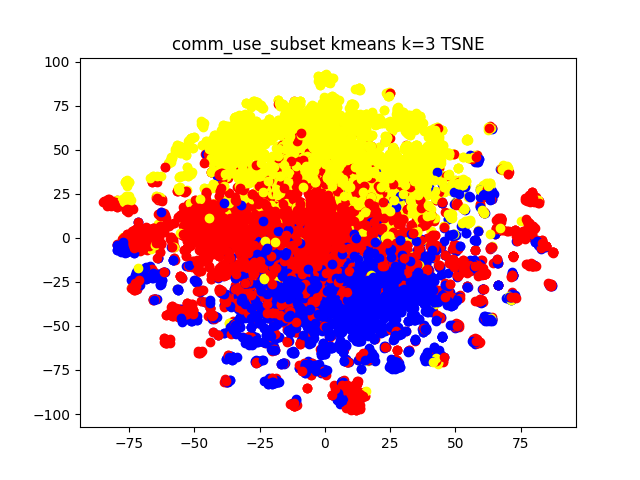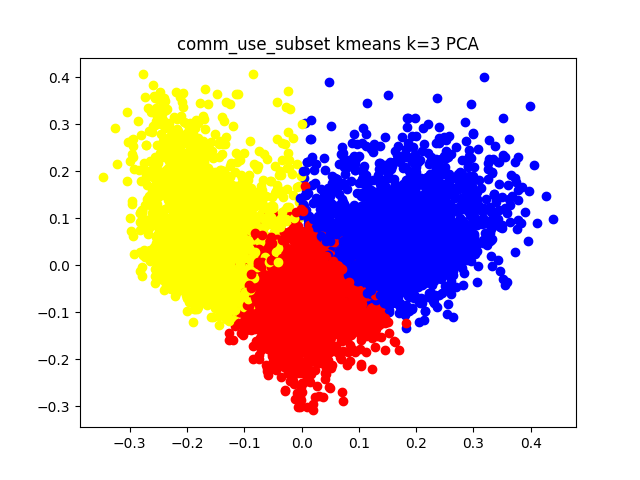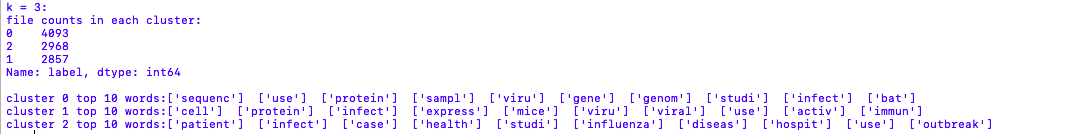
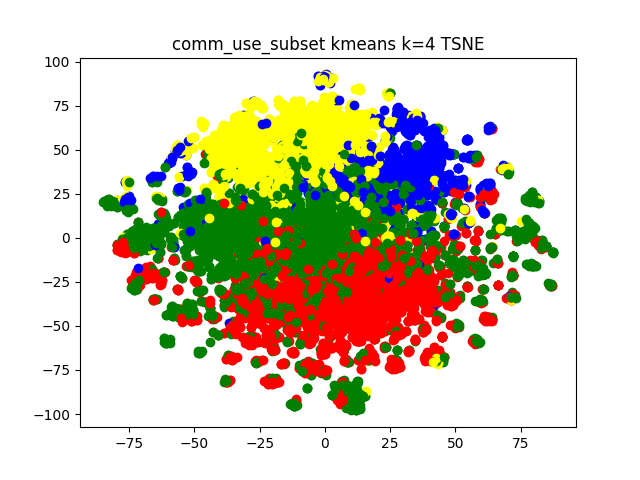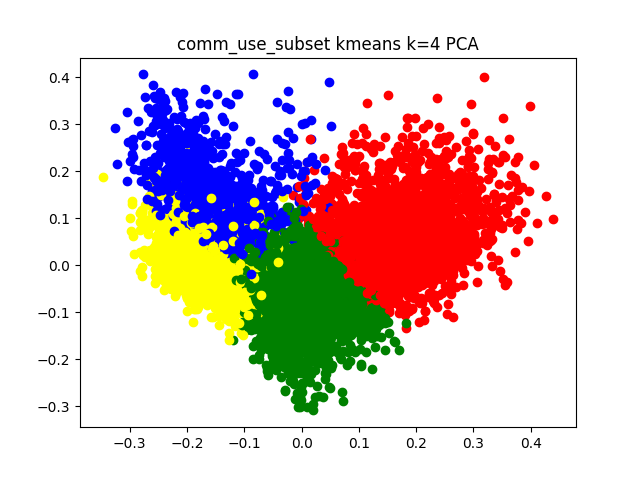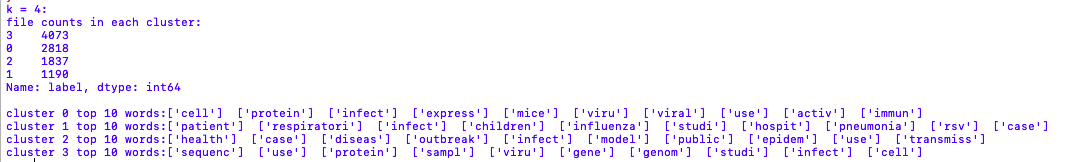
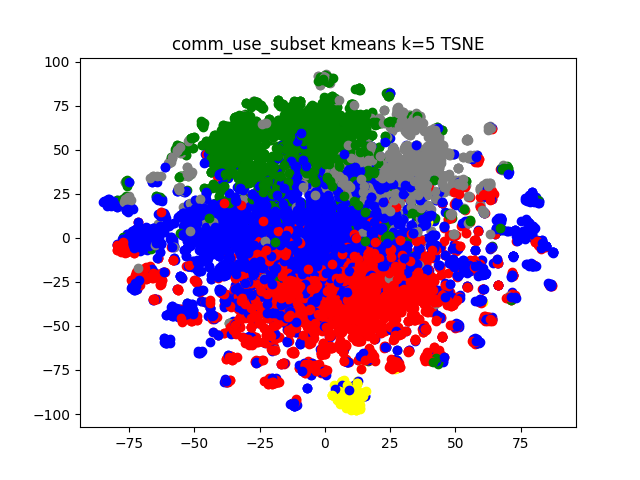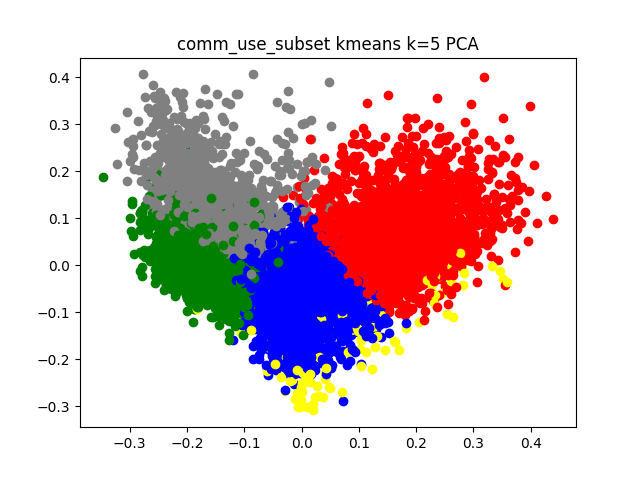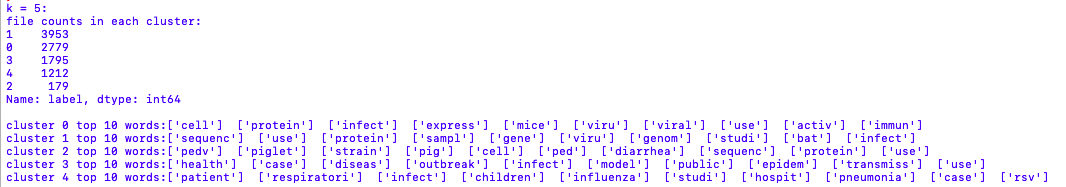
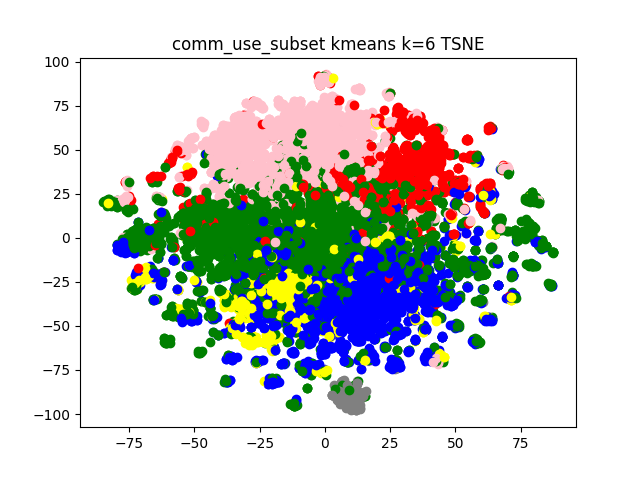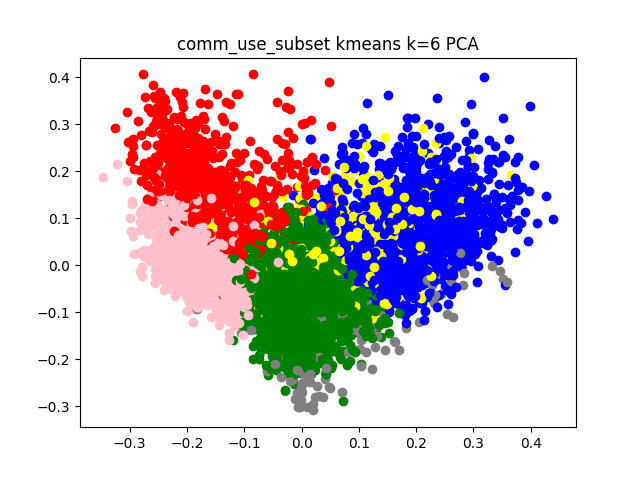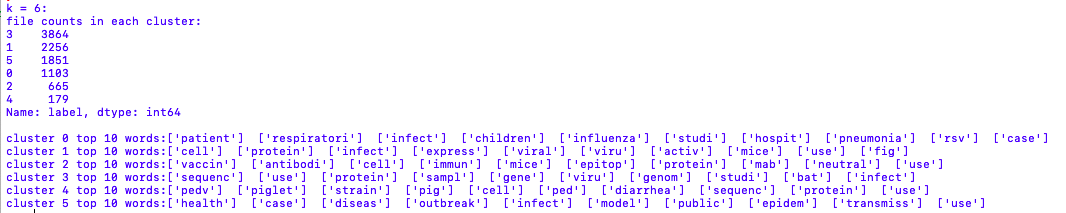
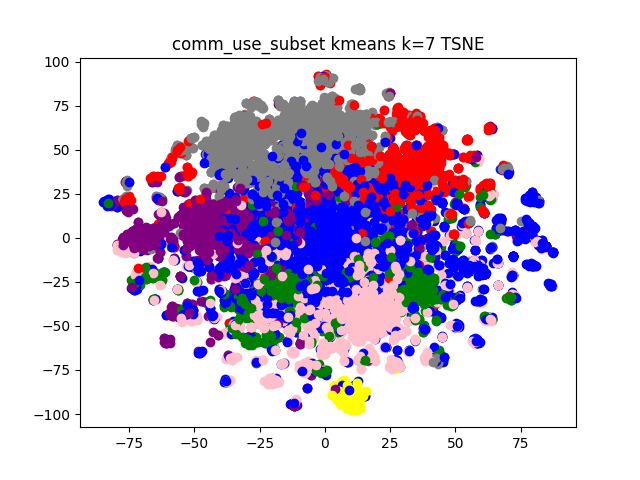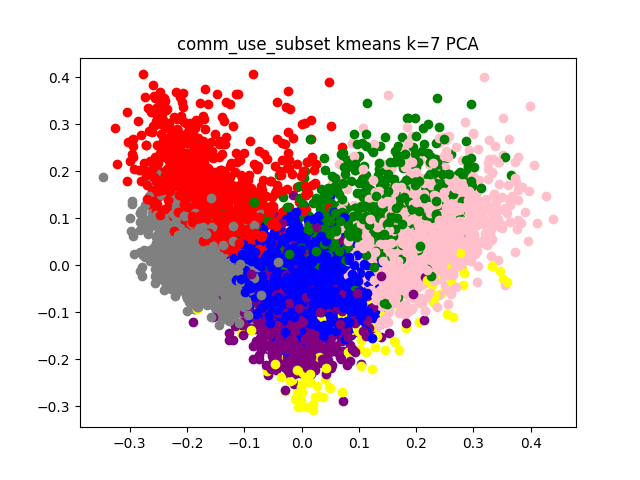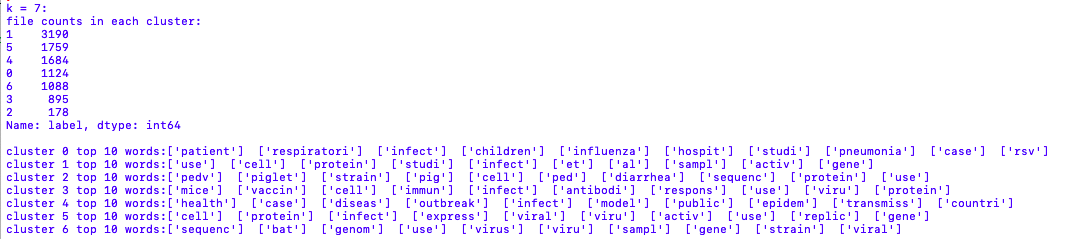
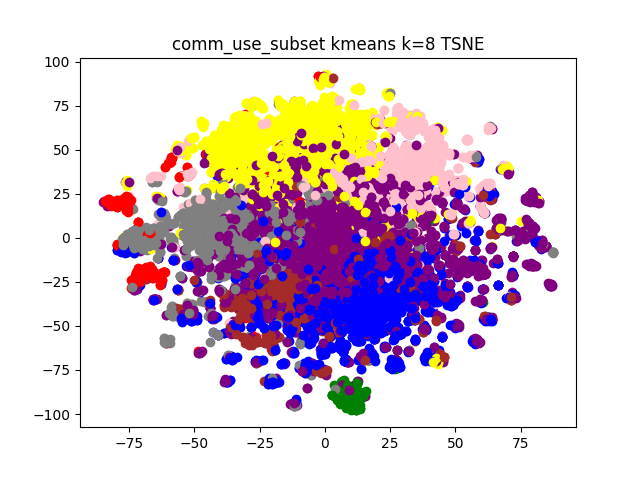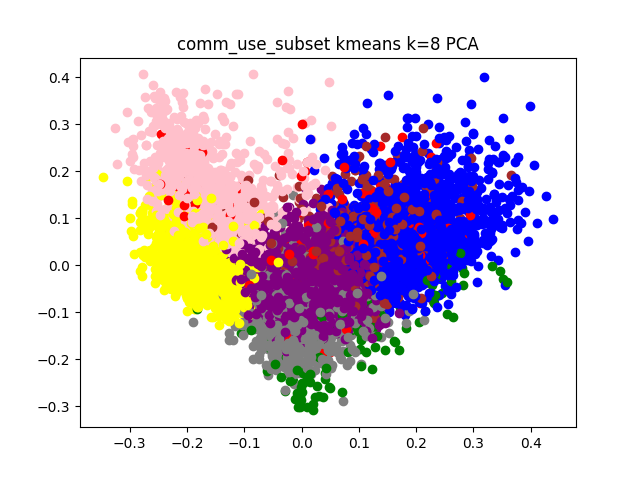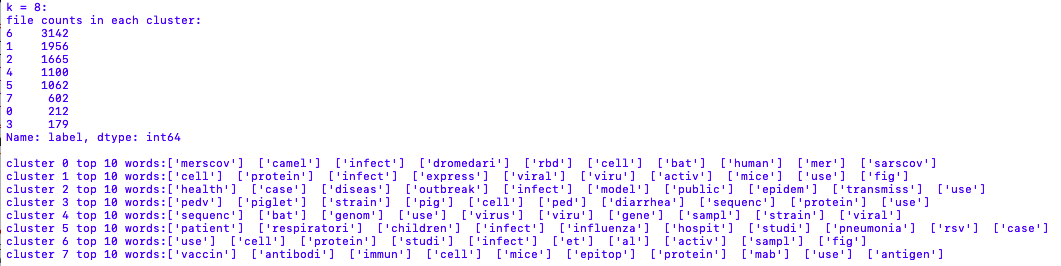

From the graphs above, K = 4 appears to be optimal, and the following words are recovered:

Cluster 0: cell, protein, infect, express, mice, virus, viral, use, active, immunity

Cluster 1: patient, respiratory, infect, children, influenza, study, hospital, pneumonia, rsv, case

Cluster 2: health, case, disease, outbreak, infect, model, public, epidemic, use, transmission

Cluster 3: sequence, use, protein, sample, virus, gene, genome, study, infect, cell

Cluster 0  outlines the cellular mechanism of the virus, the signs of activation, the use of mice as experimental subjects for observation and evidence.

Cluster1 outlines concerns about the risk of novel Coronavirus infection in pneumonia patients, with concern for children cases among them.

Cluster2 outlines the outbreak and spread of the virus among the public, and attempts to use this information to establish a propagation model.

Cluster3 outlines biological research of viruses, such as analysis of viral cell components, protein structure, and gene sequences.


## Conclusion
From the above results, it can be seen that the academic theme for the COVID-19 epidemic revolves around the following aspects: virus biological analysis and vaccine production, information modeling and factor analysis of the spread of the epidemic, and investigation of the possibility of infection of the COVID-19 virus in patients with pneumonia.